In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
access_key = 'your_access_key'
secret_key = 'your_secret_key'
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)

# If you are using Auto Loader file notification mode to load files, provide the AWS Region ID.
aws_region = "us-east-1"
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DecimalType, StringType, DateType
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [0]:
spark = SparkSession.builder.appName("sample-project").getOrCreate()

In [0]:
employees_df = spark.read.schema(employees_schema).format("csv").option("header", "true").load("s3://vijaysampleproject/employee.csv")

In [0]:
employees_schema = StructType([
    StructField("EMPLOYEE_ID", IntegerType(), True),
    StructField("FIRST_NAME", StringType(), True),
    StructField("LAST_NAME", StringType(), True),
    StructField("EMAIL", StringType(), True),
    StructField("PHONE_NUMBER", IntegerType(), True),
    StructField("HIRE_DATE", DateType(), True),
    StructField("JOB_ID", StringType(), True),
    StructField("SALARY", IntegerType(), True),
    StructField("COMMISSION_PCT", DecimalType(), True),
    StructField("MANAGER_ID", IntegerType(), True),
    StructField("DEPARTMENT_ID", IntegerType(), True)
])

In [0]:
employees_df.show()

+-----------+-----------+----------+--------+------------+---------+----------+------+--------------+----------+-------------+
|EMPLOYEE_ID| FIRST_NAME| LAST_NAME|   EMAIL|PHONE_NUMBER|HIRE_DATE|    JOB_ID|SALARY|COMMISSION_PCT|MANAGER_ID|DEPARTMENT_ID|
+-----------+-----------+----------+--------+------------+---------+----------+------+--------------+----------+-------------+
|        100|     Steven|      King|   SKING|        null|     null|   AD_PRES| 24000|          null|      null|           90|
|        101|      Neena|   Kochhar|NKOCHHAR|        null|     null|     AD_VP| 17000|          null|       100|           90|
|        102|        Lex|   De Haan| LDEHAAN|        null|     null|     AD_VP| 17000|          null|       100|           90|
|        103|  Alexander|    Hunold| AHUNOLD|        null|     null|   IT_PROG|  9000|          null|       102|           60|
|        104|      Bruce|     Ernst|  BERNST|        null|     null|   IT_PROG|  6000|          null|       103

In [0]:
departments_schema = StructType([
    StructField("DEPARTMENT_ID", IntegerType(), True),
    StructField("DEPARTMENT_NAME", StringType(), True),
    StructField("MANAGER_ID", IntegerType(), True),
    StructField("LOCATION_ID", IntegerType(), True)
])

Departments_df = spark.read.schema(departments_schema).format("csv").option("header", "true").load("s3://vijaysampleproject/departments.csv")

In [0]:
Departments_df.show()

+-------------+--------------------+----------+-----------+
|DEPARTMENT_ID|     DEPARTMENT_NAME|MANAGER_ID|LOCATION_ID|
+-------------+--------------------+----------+-----------+
|           10|      Administration|       200|       1700|
|           20|           Marketing|       201|       1800|
|           30|          Purchasing|       114|       1700|
|           40|     Human Resources|       203|       2400|
|           50|            Shipping|       121|       1500|
|           60|                  IT|       103|       1400|
|           70|    Public Relations|       204|       2700|
|           80|               Sales|       145|       2500|
|           90|           Executive|       100|       1700|
|          100|             Finance|       108|       1700|
|          110|          Accounting|       205|       1700|
|          120|            Treasury|      null|       1700|
|          130|       Corporate Tax|      null|       1700|
|          140|  Control And Credit|    

In [0]:
locations_schema = StructType([
    StructField("LOCATION_ID", IntegerType(), True),
    StructField("STREET_ADDRESS", StringType(), True),
    StructField("POSTAL_CODE", IntegerType(), True),
    StructField("CITY", IntegerType(), True),
    StructField("STATE_PROVINCE", StringType(), True),
    StructField("COUNTRY_ID", StringType(), True)
])

Loactions_df = spark.read.schema(locations_schema).format("csv").option("header", "true").load("s3://vijaysampleproject/locations.csv")

In [0]:
Loactions_df.show()

+-----------+--------------------+-----------+----+----------------+----------+
|LOCATION_ID|      STREET_ADDRESS|POSTAL_CODE|CITY|  STATE_PROVINCE|COUNTRY_ID|
+-----------+--------------------+-----------+----+----------------+----------+
|       1000|1297 Via Cola di Rie|        989|null|            null|        IT|
|       1100|93091 Calle della...|      10934|null|            null|        IT|
|       1200|    2017 Shinjuku-ku|       1689|null|Tokyo Prefecture|        JP|
|       1300|     9450 Kamiya-cho|       6823|null|            null|        JP|
|       1400| 2014 Jabberwocky Rd|      26192|null|           Texas|        US|
|       1500| 2011 Interiors Blvd|      99236|null|      California|        US|
|       1600|      2007 Zagora St|      50090|null|      New Jersey|        US|
|       1700|     2004 Charade Rd|      98199|null|      Washington|        US|
|       1800|     147 Spadina Ave|       null|null|         Ontario|        CA|
|       1900|     6092 Boxwood St|      

In [0]:
#transformation - finding out the range of salary for the employees


employees_df = employees_df.withColumn(
    "salary_range",
    when((col("salary") > 16000), "High_Salary").
    when(((col("salary") > 8000)) & (col("salary") < 16000), "Medium_Salary").
    otherwise("Low_Salary")
)


In [0]:
#transformation 2 - list out all the employees by department

windowSpec = Window.partitionBy("manager_id").orderBy("department_id")

employees_df = employees_df.withColumn(
    "dep_grouped",
    count("*").over(windowSpec)
)

In [0]:
employees_df.createOrReplaceTempView("employee")
Departments_df.createOrReplaceTempView("departments")
Loactions_df.createOrReplaceTempView("locations")


In [0]:
Employees_details = spark.sql("""
       select e.employee_id, e.first_name, e.salary, d.department_id, d.department_name, l.location_id, l.STATE_PROVINCE
       from employee e inner join departments d   
       on e.manager_id = d.manager_id 
       inner join locations l 
       on d.location_id = l.location_id                 
                              """)

In [0]:
Employees_details.show()

+-----------+-----------+------+-------------+---------------+-----------+--------------+
|employee_id| first_name|salary|department_id|department_name|location_id|STATE_PROVINCE|
+-----------+-----------+------+-------------+---------------+-----------+--------------+
|        101|      Neena| 17000|           90|      Executive|       1700|    Washington|
|        102|        Lex| 17000|           90|      Executive|       1700|    Washington|
|        104|      Bruce|  6000|           60|             IT|       1400|         Texas|
|        105|      David|  4800|           60|             IT|       1400|         Texas|
|        106|      Valli|  4800|           60|             IT|       1400|         Texas|
|        107|      Diana|  4200|           60|             IT|       1400|         Texas|
|        109|     Daniel|  9000|          100|        Finance|       1700|    Washington|
|        110|       John|  8200|          100|        Finance|       1700|    Washington|
|        1

In [0]:
Employees_details.show()

+-----------+-----------+------+-------------+---------------+-----------+--------------+
|employee_id| first_name|salary|department_id|department_name|location_id|STATE_PROVINCE|
+-----------+-----------+------+-------------+---------------+-----------+--------------+
|        101|      Neena| 17000|           90|      Executive|       1700|    Washington|
|        102|        Lex| 17000|           90|      Executive|       1700|    Washington|
|        104|      Bruce|  6000|           60|             IT|       1400|         Texas|
|        105|      David|  4800|           60|             IT|       1400|         Texas|
|        106|      Valli|  4800|           60|             IT|       1400|         Texas|
|        107|      Diana|  4200|           60|             IT|       1400|         Texas|
|        109|     Daniel|  9000|          100|        Finance|       1700|    Washington|
|        110|       John|  8200|          100|        Finance|       1700|    Washington|
|        1

In [0]:

import matplotlib.pyplot as plt


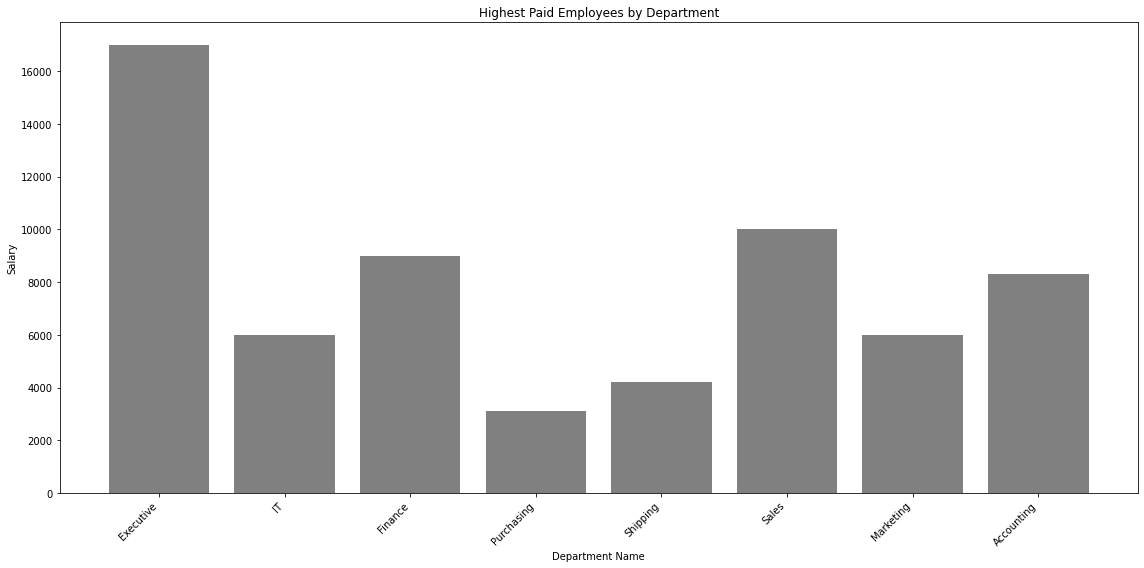

In [0]:
# Convert to Pandas for Plotting
Employees_details_pd = Employees_details.toPandas()

# Visualizing using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Limiting to top 10 by salary
top_employees = Employees_details_pd

# Plotting
plt.bar(top_employees['department_name'], top_employees['salary'], color='grey')
plt.xlabel('Department Name')
plt.ylabel('Salary')
plt.title('Highest Paid Employees by Department')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()